# Capstone Project - The Battle of the Neighborhoods

## Introduction

In an increasingly globalized world, internationally operating companies are required to post their employees to different locations all over the world. There are multiple reasons for staff deployment across all types of industries, e.g. due to a lack of qualified personnel at foreign locations. Further reasons might be knowledge sharing across different locations, international project teams, improving the communication between the headquarter and abroad locations and many more.

The goal of this project is to provide valuable insights and support for human resources departments that have to deal with staff deployment in terms of the following aspects and questions respectively:

-	Based on the personal preferences of an employee, which neighborhood(s) of the target city should be chosen to book a hotel or rent a project apartment for the duration of the deployment abroad?

-	An employee might prefer a neighborhood with similar culture and lifestyle compared to where he/she currently lives.
On the other hand, employees might deliberately be looking for a specific neighborhood that differs from the one they currently live in. 

-	Enabling employees to live in a neighborhood they prefer, might result in increased willingness to be posted abroad as well as increased employee satisfaction.

-	Are there neighborhoods that should be avoided due to very high crime rates?

The issues above will be addressed by segmenting and clustering neighborhoods based on venue data reflecting the culture and lifestyle of the respective area.

In this project, let us assume there is a Munich-based company regularly sending employees to locations in Detroit and Mexico City respectively.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Import and Prepare Neighborhood Data</a>

2. <a href="#item2">Import and Prepare Crime Data</a>

3. <a href="#item3">Visualize and Analyze Neighborhoods</a>

4. <a href="#item4">Analyze Crime</a>

5. <a href="#item5">Cluster Neighborhoods</a>
    
6. <a href="#item6">Examine Clusters</a>
</font>
</div>

First, let's install and import all libraries and modules required for the project.

In [1]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library

# set pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# import plotting library
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# install and import module to convert kml to geojson file
#!pip install kml2geojson
import kml2geojson

# import module to work with json data
import json

# Python module required to calculate a centroid-like point based on polygonial shape data
#!pip install shapely
import shapely
from shapely.geometry import Polygon

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from folium import plugins

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# !pip install selenium
import selenium.webdriver

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# install wordcloud
# !pip install wordcloud
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

<a id='item1'></a>

## 1. Import and Prepare Neighborhood Data

In the following, the datasets containing district and neighborhood data for Munich, Detroit and Mexico City will be imported into pandas dataframes for further processing. The data will be manipulated and prepared such that we end up with the following information.

* district
* neighborhood
* acres (for Detroit only)
* latitude coordinate of neighborhood
* longitude coordinate of neighborhood

### Create a Dataframe containing Munich Neighborhood Data

In the case of Munich, district and neighborhood data is only available in two separate files.

First, let's get the data for Munich districts provided by the Open Data Portal Munich and manipulate it accordingly. 

In [2]:
df_munich_dis = pd.read_csv('https://www.opengov-muenchen.de/dataset/e3f5dbd2-39cc-40cd-bc91-4bb49a0b1802/resource/a641ce6a-4e01-4f4b-9976-1ae6a47e3762/download/jt140102.csv')

# create new column 'district_id'
df_munich_dis['district_id']=df_munich_dis['stadtbezirk'].str.strip().str.extract('(\d+).')

# create new column 'district_name' 
df_munich_dis['district']=df_munich_dis['stadtbezirk'].str.strip().str.extract('(\D+)')

# remove '\n' from row 18
df_munich_dis['district'] = df_munich_dis['district'].str.strip().str.replace('\n', '')

# drop columns we don't need
df_munich_dis = df_munich_dis.drop(['stadtbezirk','einwohner', 'flaeche', 'einwohnerdichte', 'anteil_an_gesamtbevoelkerung'], axis=1)

# remove last row
df_munich_dis = df_munich_dis[df_munich_dis['district']!="nicht zuzuordnen"]

df_munich_dis.head()

district_id                        district
0           1                Altstadt - Lehel
1           2  Ludwigsvorstadt - Isarvorstadt
2           3                     Maxvorstadt
3           4                  Schwabing West
4           5                 Au - Haidhausen

The column *district_id* will be used to join the dataframes containing districts and neighborhoods.

Next, import the dataset containing Munich neighborhoods and clean it up as well.

In [3]:
df_munich_neigh = pd.read_csv('https://www.opengov-muenchen.de/dataset/15aa8720-cd0c-45db-ba37-d90924a9dc5c/resource/ffcdc8ec-1fc4-4186-9fbf-9114448e80a7/download/bevoelkerunghws201712stadtbezirksteile.csv')

# create column neighborhood
df_munich_neigh['neighborhood'] = df_munich_neigh['bezirksteil_bezeichnung'].str.strip().str.extract('\d{2}.\d{1} (.*)')

# create column district_id
df_munich_neigh['district_id'] = df_munich_neigh['bezirksteil_bezeichnung'].str.strip().str.extract('0?(\d*)\D')

# get rid of columns we don't need
df_munich_neigh = df_munich_neigh.drop(columns=['bezirksteil_bezeichnung', 'hauptwohnsitzbevölkerung'])

# re-arrange columns
df_munich_neigh = df_munich_neigh[['district_id', 'neighborhood']]

# remove duplicate neighborhood 'Oberföhring'
df_munich_neigh.drop_duplicates(inplace=True)

df_munich_neigh.head()

district_id   neighborhood
0           1      Graggenau
1           1   Angerviertel
2           1  Hackenviertel
3           1   Kreuzviertel
4           1          Lehel

Now we are ready to merge the two dataframes ...

In [4]:
df_munich = df_munich_neigh.merge(df_munich_dis, left_on='district_id', right_on='district_id')

# only keep relevant columns
df_munich = df_munich[['district', 'neighborhood']]

df_munich.head()

district   neighborhood
0  Altstadt - Lehel      Graggenau
1  Altstadt - Lehel   Angerviertel
2  Altstadt - Lehel  Hackenviertel
3  Altstadt - Lehel   Kreuzviertel
4  Altstadt - Lehel          Lehel

#### Get Geographic Coordinates for Munich Neighborhoods

In order to retrieve venue data via the Foursquare API we require geographic coordinates for the neighborhoods of our cities. Fortunately, latitude and longitude coordinate data is already provided in the dataset for Mexico City. Also, coordinates for the neighborhoods of Detroit can be derived from the respective polygonial shape data. 
Thus, we only need to get the coordinates for Munich neighborhoods. This can be done via reverse geocoding, i.e. neighborhood address is passed through to the *geopy* library in order to receive the respective coordinates.

Let's request coordinates for all Munich neighborhoods in the respective dataframe.

In [5]:
# initialize lists for latitude and longitude coordinates
latitude = list()
longitude = list()

# create Nominatim object
geolocator = Nominatim(user_agent="city_explorer", timeout=3)

# loop through df_munich and request coordinates for all neighborhoods
for neigh in df_munich['neighborhood']:
    address = neigh + ", Munich"
    # print(address)
    try:
        location = geolocator.geocode(address)
        lat = location.latitude
        long = location.longitude
        latitude.append(lat)
        longitude.append(long)
    except:
        print("No data available for", address)
        latitude.append(None)
        longitude.append(None)

No data available for Land in Sonne, Munich
No data available for Berg am Laim Ost, Munich


In [6]:
# add coordinates to dataframe
df_munich['latitude'] = latitude
df_munich['longitude'] = longitude

Note that for some neighborhoods no geographic coordinates could be retrieved via *geopy* using Nominatim. These neighborhoods will be removed from the dataframe and as a result no venue data will be retrieved for these neighborhoods when we do the clustering.

In [7]:
# only keep neighborhoods where coordinates could be retrieved
df_munich = df_munich[df_munich['latitude'].notnull()]

df_munich.reset_index(drop=True, inplace=True)

df_munich.head()

district   neighborhood   latitude  longitude
0  Altstadt - Lehel      Graggenau  48.139616  11.579513
1  Altstadt - Lehel   Angerviertel  48.133670  11.571569
2  Altstadt - Lehel  Hackenviertel  48.135731  11.569955
3  Altstadt - Lehel   Kreuzviertel  48.139698  11.573209
4  Altstadt - Lehel          Lehel  48.139656  11.587921

### Create a Dataframe containing Detroit Neighborhood Data

Let's get the data for Detroit districts and neighborhoods. On the City of Detroit Open Data Portal, a kml file is provided containing all informations we require. First, let's use the *kml2geojson* module in order to convert the file to geojson format which is easy to handle in Python.

In [8]:
# convert kml file to geojson format
kml2geojson.main.convert('data/detroit/neighborhoods.kml', 'data/detroit/kml2geojson')

Next, we can read the geojson file such that the data is available as dictionary.

In [9]:
with open('data/detroit/kml2geojson/neighborhoods.geojson') as json_file:
    detroit_data = json.load(json_file)
    
type(detroit_data)

dict

For later purposes (retrieving venue data via the Foursquare API) we require geographic coordinates for all neighborhoods. As there is only polygonial data (i.e. a set of coordinates defining the shape of each neighborhood) available in the geojson file, center coordinates (i.e. a geographic point) can be calculated using the Polygon class of the *shapely* module. 

The district and neighborhood data along with the calculated coordinates are saved in a dataframe.

In [10]:
# initialize dataframe
df_detroit = pd.DataFrame(columns=['district', 'neighborhood', 'acres', 'latitude', 'longitude'])

# loop through the json file and write data to dataframe
for i in range(0, len(detroit_data['features'])):
    polygon = Polygon(detroit_data['features'][i]['geometry']['coordinates'][0]) # create a Polygon object for each neighborhood
    
    df_detroit = df_detroit.append({'district': detroit_data['features'][i]['properties']['district_n'],
                    'neighborhood': detroit_data['features'][i]['properties']['new_nhood'],
                    'acres': detroit_data['features'][i]['properties']['acres'],
                    'latitude': polygon.representative_point().y,
                    'longitude': polygon.representative_point().x},ignore_index=True)

# sort dataframe and reset index
df_detroit.sort_values(by='district', inplace=True)
df_detroit.reset_index(drop=True, inplace=True)

In [11]:
df_detroit.head()

district          neighborhood          acres   latitude  longitude
0        1          Castle Rouge  223.664932556  42.381679 -83.268125
1        1               Belmont  160.505885742  42.405253 -83.193969
2        1  Grand River-St Marys  204.652860686  42.397070 -83.203921
3        1        Hubbell-Lyndon   312.92226405  42.394404 -83.191321
4        1       Hubbell-Puritan  234.849353366  42.413254 -83.192117

Note that the column acres will be used at a later stage when analyzing crime rate data for Detroit.

### Create a Dataframe containing Mexico City Neighborhood Data

Finally, let's get the data for Mexico city districts and neighborhoods. Fortunately, geographic coordinates for all neighborhoods of Mexico City are included in the file.

In [12]:
df_mexico_city = pd.read_csv('data/mexico_city/neighborhoods.csv')

# create columns latitude and longitude
df_mexico_city['latitude'] = df_mexico_city['Geo Point'].str.strip().str.extract('(.*),.*')
df_mexico_city['longitude'] = df_mexico_city['Geo Point'].str.strip().str.extract('.*,(.*)')

# rename columns
df_mexico_city.rename(columns={'COLONIA': 'neighborhood', 'ALCALDIA': 'district'}, inplace=True)

# sort dataframe by districts
df_mexico_city.sort_values(by='CVE_ALC', inplace=True)

df_mexico_city = df_mexico_city[['district', 'neighborhood', 'latitude', 'longitude']]

# remove rows where no coordinates are provided
removed = df_mexico_city[df_mexico_city['latitude'].isnull()].shape[0]
df_mexico_city = df_mexico_city[df_mexico_city['latitude'].notnull()]

# convert coordinates columns 
df_mexico_city['latitude'] = df_mexico_city['latitude'].astype('float64')
df_mexico_city['longitude'] = df_mexico_city['longitude'].astype('float64')

# print("{} neighborhoods have been removed from the dataset due to missing geographic coordinates.\n".format(removed))

df_mexico_city.reset_index(drop=True, inplace=True)
df_mexico_city.head()

district                   neighborhood   latitude  longitude
0  AZCAPOTZALCO                      PETROLERA  19.485156 -99.199994
1  AZCAPOTZALCO                         ALDANA  19.470737 -99.149997
2  AZCAPOTZALCO                    COSMOPOLITA  19.474806 -99.163333
3  AZCAPOTZALCO           AMPLIACION PETROLERA  19.483038 -99.195313
4  AZCAPOTZALCO  HUAUTLA DE LAS SALINAS (BARR)  19.488979 -99.159303

<a id='item2'></a>

## 2. Import and Prepare Crime Data

In contrast to Munich, Detroit and Mexico City are known as cities with moderate to high crime level and it seems reasonable to exclude areas with high crime rates.
For this purpose, crime data needs to be imported and prepared for further analysis.

### Import and Prepare Crime Data for Detroit

A dataset providing crime incidents in Detroit is available on the City of Detroit Open Data Portal.
There is some data manipulation and preparation required in order to add crime information to the Detroit dataframe.

In [13]:
# read in file containing crime incident data
df_detroit_crime = pd.read_csv('data/detroit/crime_incidents.csv')

# reduce the amount of data by only keeping 2019 data
df_detroit_crime = df_detroit_crime[df_detroit_crime['year']==2019]

# filter and rename columns
df_detroit_crime = df_detroit_crime[['council_district','neighborhood', 'offense_category', 'latitude', 'longitude']]
df_detroit_crime.rename(columns={'council_district': 'district', 'offense_category': 'incidents'}, inplace=True)

# aggregate incident count on a district, neighborhood level
df_detroit_crime_by_neigh = df_detroit_crime.groupby(['district','neighborhood'])['incidents'].count().reset_index()
df_detroit_crime_by_neigh.sort_values(by='neighborhood')

# extract and save data for neighborhood 'Oak Grove' prior to aggregating on neighborhood level
df_oak_grove = df_detroit_crime_by_neigh[df_detroit_crime_by_neigh['neighborhood']=='Oak Grove']
df_oak_grove.set_index(['district','neighborhood'], inplace=True)

# aggregate crime incident count on neighborhood level
df_detroit_crime_by_neigh = df_detroit_crime.groupby(['neighborhood'])['incidents'].count().reset_index()

# remove data for 'Oak Grove' from dataset before merging with df_detroit
df_detroit_crime_by_neigh = df_detroit_crime_by_neigh[df_detroit_crime_by_neigh['neighborhood']!='Oak Grove'].reset_index(drop=True)

# add crime data to df_detroit
df_detroit = df_detroit.merge(df_detroit_crime_by_neigh, how='left', left_on='neighborhood', right_on='neighborhood')

# add crime data for 'Oak Grove'
df_detroit.set_index(['district', 'neighborhood'], inplace=True)
df_detroit.loc[('1','Oak Grove'),'incidents'] = df_oak_grove.loc[(1, 'Oak Grove'), 'incidents']
df_detroit.loc[('2','Oak Grove'),'incidents'] = df_oak_grove.loc[(2, 'Oak Grove'), 'incidents']

df_detroit.reset_index(inplace=True)

# add column crime rate that gives the number of crime incidents per acre
df_detroit['acres'] = df_detroit['acres'].astype('float64')
df_detroit['crime rate'] = df_detroit['incidents'] / df_detroit['acres']

df_detroit.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


district          neighborhood       acres   latitude  longitude  incidents  \
0        1          Castle Rouge  223.664933  42.381679 -83.268125      207.0   
1        1               Belmont  160.505886  42.405253 -83.193969      296.0   
2        1  Grand River-St Marys  204.652861  42.397070 -83.203921      417.0   
3        1        Hubbell-Lyndon  312.922264  42.394404 -83.191321      566.0   
4        1       Hubbell-Puritan  234.849353  42.413254 -83.192117      374.0   

   crime rate  
0    0.925492  
1    1.844169  
2    2.037597  
3    1.808756  
4    1.592510

### Import and Prepare Crime Data for Mexico City

Let's now import the crime data for Mexico City. Note that due to data quality issues it is only feasible to consider crime data on a district level rather than neighborhood level as done for Detroit. There are a few data manipulations required in order to get the data in a form that enables us visualize and analyze it properly.

In [14]:
# read file containing crime data for Mexico City
df_mexico_city_crime = pd.read_csv('data/mexico_city/crime_incidents_2019.csv')

# filter columns
df_mexico_city_crime = df_mexico_city_crime[['delito','categoria_delito', 'colonia_hechos', 'alcaldia_hechos', 'calle_hechos']]

# create dataframe crime by district
df_mexico_city_crime_by_district = df_mexico_city_crime.groupby(['alcaldia_hechos']).count().reset_index()[['alcaldia_hechos', 'delito']]

# rename columns
df_mexico_city_crime_by_district.rename(columns={'alcaldia_hechos': 'district', 'delito': 'incidents'}, inplace=True)

# only keep districts contained in the 16 major districts
districts = df_mexico_city['district'].drop_duplicates().str.replace('.', '').tolist()
df_mexico_city_crime_by_district = df_mexico_city_crime_by_district[df_mexico_city_crime_by_district['district'].isin(districts)]

# adjust dictrict spelling to be in line with district geojson file
df_mexico_city_crime_by_district['district'] = df_mexico_city_crime_by_district['district'].str.title()
df_mexico_city_crime_by_district.loc[df_mexico_city_crime_by_district['district']=='Alvaro Obregon', 'district'] = 'Álvaro Obregón'
df_mexico_city_crime_by_district.loc[df_mexico_city_crime_by_district['district']=='Benito Juarez', 'district'] = 'Benito Juárez'
df_mexico_city_crime_by_district.loc[df_mexico_city_crime_by_district['district']=='Coyoacan', 'district'] = 'Coyoacán'
df_mexico_city_crime_by_district.loc[df_mexico_city_crime_by_district['district']=='Cuajimalpa De Morelos', 'district'] = 'Cuajimalpa de Morelos'
df_mexico_city_crime_by_district.loc[df_mexico_city_crime_by_district['district']=='Cuauhtemoc', 'district'] = 'Cuauhtémoc'
df_mexico_city_crime_by_district.loc[df_mexico_city_crime_by_district['district']=='Gustavo A Madero', 'district'] = 'Gustavo A. Madero'
df_mexico_city_crime_by_district.loc[df_mexico_city_crime_by_district['district']=='Tlahuac', 'district'] = 'Tláhuac'

df_mexico_city_crime_by_district

district  incidents
9            Álvaro Obregón       8324
18             Azcapotzalco       5107
19            Benito Juárez       9478
38                 Coyoacán       7156
40    Cuajimalpa de Morelos       1696
41               Cuauhtémoc      16806
53        Gustavo A. Madero      11644
66                Iztacalco       5060
67               Iztapalapa      17848
74   La Magdalena Contreras       1886
85           Miguel Hidalgo       7347
86               Milpa Alta        744
136                 Tláhuac       2706
140                 Tlalpan       6456
152     Venustiano Carranza       6720
160              Xochimilco       3422

<a id='item3'></a>

## 3. Visualize and Analyze Neighborhoods 

Let's have a closer look at the neighborhood data for Munich, Detroit and Mexico City and check the number of districts and neighborhoods in those cities.

In [15]:
print("Munich consists of {dis} districts and {neigh} neighborhoods.".format(dis=len(set(df_munich['district'])), neigh=len(set(df_munich['neighborhood']))))
print("Detroit consists of {dis} districts and {neigh} neighborhoods.".format(dis=len(set(df_detroit['district'])), neigh=len(set(df_detroit['neighborhood']))))
print("Mexico City consists of {dis} districts and {neigh} neighborhoods.\n".format(dis=len(set(df_mexico_city['district'])), neigh=len(set(df_mexico_city['neighborhood']))))

Munich consists of 25 districts and 106 neighborhoods.
Detroit consists of 7 districts and 207 neighborhoods.
Mexico City consists of 16 districts and 1739 neighborhoods.



### Visualize Neighborhoods

We can visualize the extracted neighborhoods using the *folium* library. However, before visualizing the neighborhoods of Munich, Detroit and Mexico City we still need to request the geographical coordinates for these cities. Similar to the extraction of the neighborhood coordinates for Munich, this can be achieved using the *geopy* library.

In [16]:
addresses = ['Munich, Germany', 'Detroit, Michigan', 'Mexico City, Mexico']
geolocator = Nominatim(user_agent="city_explorer")

# create dataframe
city_locations = pd.DataFrame(columns=['latitude', 'longitude'], index = addresses)

for address in addresses:
    location = geolocator.geocode(address)
    city_locations.loc[address, 'latitude'] = location.latitude
    city_locations.loc[address, 'longitude'] = location.longitude

city_locations

latitude longitude
Munich, Germany      48.1371   11.5754
Detroit, Michigan    42.3316  -83.0466
Mexico City, Mexico  19.4326  -99.1332

Now we are ready to plot a map of our cities together with markers for their neighborhoods and districts.

#### Visualize Munich Neighborhoods

In [17]:
# create map of Munich using latitude and longitude values
map_munich = folium.Map(location=[city_locations.iloc[0, 0], city_locations.iloc[0,1]], zoom_start=12, control_scale=True)

# neighborhoods = plugins.MarkerCluster().add_to(map_munich)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_munich['latitude'], df_munich['longitude'], df_munich['district'], df_munich['neighborhood']):
    label = '{} ({})'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_munich)
    
map_munich

#### Visualize Detroit Neighborhoods

In [18]:
# create map of Detroit using latitude and longitude values
# map_detroit = folium.Map(location=[city_locations.iloc[1, 0], city_locations.iloc[1,1]], zoom_start=11, control_scale=True)
map_detroit = folium.Map(location=[42.361650, -83.093222], zoom_start = 12, control_scale=True)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_detroit['latitude'], df_detroit['longitude'], df_detroit['district'], df_detroit['neighborhood']):
    label = '{} ({})'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_detroit)
#         parse_html=False).add_to(neighborhoods)
    
map_detroit

#### Visualize Mexico City Neighborhoods

In [20]:
# # create map of Mexico City using latitude and longitude values
# map_mexico_city = folium.Map(location=[city_locations.iloc[2, 0], city_locations.iloc[2,1]], zoom_start=11, control_scale=True)

# # add markers to map
# for lat, lng, borough, neighborhood in zip(df_mexico_city['latitude'], df_mexico_city['longitude'], df_mexico_city['district'], df_mexico_city['neighborhood']):
#     label = '{} ({})'.format(neighborhood, borough)
#     label = folium.Popup(label, parse_html=True)
#     folium.features.CircleMarker(
#         [lat, lng],
#         radius=5,
#         popup=label,
#         color='yellow',
#         fill=True,
#         fill_color='blue',
#         fill_opacity=0.7,
#         parse_html=False).add_to(map_mexico_city)
# #         parse_html=False).add_to(neighborhoods)
    
# map_mexico_city

The visualization part of Mexico City's Neighborhoods is commented out due to the large number of neighborhoods to be displayed. Feel free to uncomment the cell above to run the visualization.

<a id='item4'></a>

## 4. Analyze Crime

We can create a choropleth map of Detroit and Mexico City to figure out areas with high crime rates. The idea is to avoid neighborhoods with high crime rates and to exclude such areas from our datasets.

### Analyze Crime in Detroit

In [21]:
detroit_geo = 'data/detroit/kml2geojson/neighborhoods.geojson' # geojson file

# create a plain map of Detroit
# map_detroit_choro = folium.Map(location=[city_locations.iloc[1, 0], city_locations.iloc[1,1]], zoom_start = 12, control_scale=True)
map_detroit_choro = folium.Map(location=[42.361650, -83.093222], zoom_start = 12, control_scale=True)

# create bins based on quantiles for the legend
bins = (df_detroit['crime rate'].quantile([0.0, 0.25, 0.75, 0.95, 1])).tolist()
bins[-1] = bins[-1] + 0.1

# generate choropleth map using the total number of crime incidents per neighboorhood in 2019
map_detroit_choro.choropleth(
    geo_data=detroit_geo,
    data=df_detroit,
    columns=['neighborhood', 'crime rate'],
    key_on='feature.properties.new_nhood',
#     fill_color='YlGnBu',
    fill_color='YlOrRd',
    fill_opacity=0.6, 
    line_opacity=0.7,
    legend_name='crime rate (crime incidents / acre)',
    threshold_scale=bins,
    reset=True
)

# # add markers to map
# for lat, lng, borough, neighborhood in zip(df_detroit['latitude'], df_detroit['longitude'], df_detroit['district'], df_detroit['neighborhood']):
#     label = '{} ({})'.format(neighborhood, borough)
#     label = folium.Popup(label, parse_html=True)
#     folium.features.CircleMarker(
#         [lat, lng],
#         radius=5,
#         popup=label,
#         color='yellow',
#         fill=True,
#         fill_color='blue',
#         fill_opacity=0.7,
#         parse_html=False).add_to(map_detroit_choro)
# #         parse_html=False).add_to(neighborhoods)

# display map
map_detroit_choro

The neighborhoods having a crime rate (total number of crime incidents per acre) that exceeds the 95% quantile are reflected by the dark red color in the choropleth map above.

So, let's have a look at the worst 5% neighborhoods in terms of crime ...

In [22]:
print(df_detroit['crime rate'].quantile(0.95), '\n')
df_detroit[df_detroit['crime rate'] > df_detroit['crime rate'].quantile(0.95)]

2.0660832574510106 



district            neighborhood       acres   latitude  longitude  \
8          1  Greenfield-Grand River  169.487311  42.392204 -83.203237   
93         4         Yorkshire Woods  291.655867  42.418947 -82.943249   
94         4                   Denby  222.020554  42.423408 -82.955329   
112        5               Greektown   30.722143  42.335265 -83.041247   
114        5              New Center   76.437563  42.368393 -83.077354   
115        5          Brewster Homes   38.036042  42.348596 -83.049056   
137        5      New Center Commons  100.854452  42.372179 -83.079957   
140        5              Brush Park  117.900555  42.344622 -83.052540   
170        6                Downtown  594.749026  42.333758 -83.054207   
171        6                Jeffries   78.712441  42.346917 -83.071773   
178        6                 Midtown  384.915022  42.346177 -83.063305   

     incidents  crime rate  
8        424.0    2.501662  
93       607.0    2.081220  
94       479.0    2.157458  
112      460.0   14.972914  
114      184.0    2.407193  
115      104.0    2.734249  
137      225.0    2.230938  
140      284.0    2.408810  
170     2107.0    3.542671  
171      171.0    2.172465  
178     1563.0    4.060637

As can be seen from the dataframe above there are in total eleven neighborhoods that exceed the 95% quantile of 2.07 crimes per acre.

Let's now get some more insights by displaying a histogram and boxplot of the crime rate column.

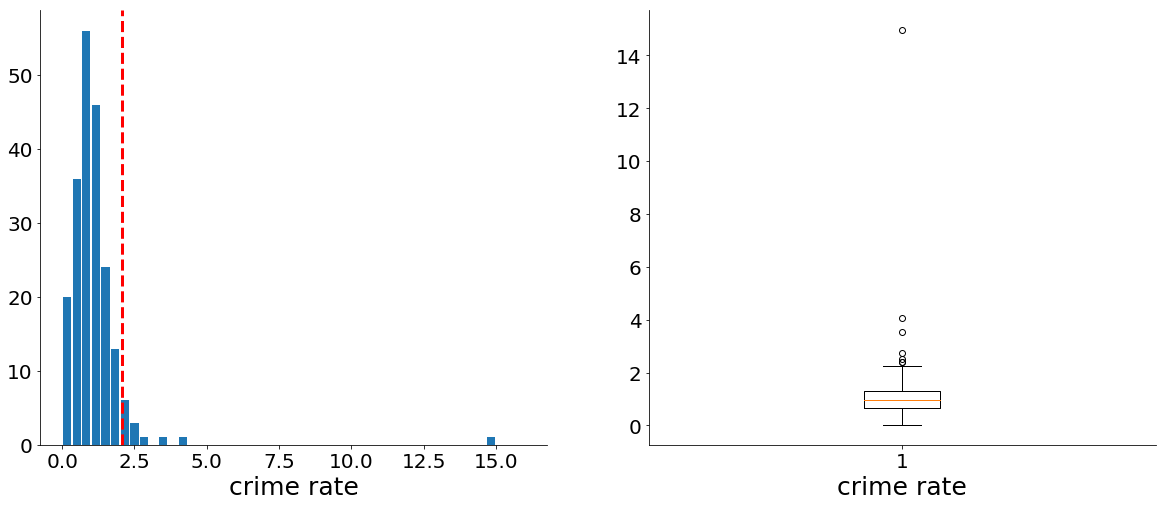

In [23]:
fig = plt.figure(figsize=(20,8))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

bins=np.linspace(0, 16, num=49)
#bins=list(df_detroit_crime_by_neigh['crime_num_adj'].quantile([0.0, 0.25, 0.5, 0.75,0.95, 1]))

# add histogram to figure
hist = ax0.hist(df_detroit['crime rate'], bins=bins , rwidth=0.85)
vertline = ax0.axvline(x=df_detroit['crime rate'].quantile(0.95), linestyle='--', linewidth=3, color='red') # create vertical line indicating quantile
hist_xlabel = ax0.set_xlabel('crime rate', fontsize=25)
ticks = ax0.tick_params(labelsize=20)

# add boxplot to figure
box = ax1.boxplot(df_detroit['crime rate'])
box_label = ax1.set_xlabel('crime rate', fontsize=25)
ticks = ax1.tick_params(labelsize=20)
fig.savefig('sample.jpg', bbox_inches='tight')


Looking at the histogram above, it appears to be reasonable to exclude all neighborhoods that exceed the 95% quantile for further considerations. We can easily apply this to our dataframe for Detroit neighborhood data noting that this reduces the size of the dataframe.

In [24]:
df_detroit = df_detroit[df_detroit['crime rate'] <= df_detroit['crime rate'].quantile(0.95)]
df_detroit.shape

(197, 7)

### Analyze Crime in Mexico City

Similar vizualization and analysis can be applied to Mexico City. However, as already mentioned it is not feasible to perform crime analysis for Mexico City on a neighborhood level due to unsatisfying data quality. Thus, the analysis is done on a district basis.

In [25]:
mexico_city_geo = 'data/mexico_city/alcaldias.geojson' # geojson file

# create a plain map of Mexico City
# map_mexico_city_choro = folium.Map(location=[city_locations.iloc[2, 0], city_locations.iloc[2,1]], zoom_start=11, control_scale=True)
map_mexico_city_choro = folium.Map(location=[19.321834, -99.134788], zoom_start=11, control_scale=True)


# create bins based on quantiles for the legend
bins = (df_mexico_city_crime_by_district['incidents'].quantile([0.0, 0.25, 0.5, 0.75, 1])).tolist()
bins[-1] = bins[-1] + 0.1

# generate choropleth map using the total number of crime incidents per neighboorhood in 2019
map_mexico_city_choro.choropleth(
    geo_data=mexico_city_geo,
    data=df_mexico_city_crime_by_district,
    columns=['district', 'incidents'],
    key_on='feature.properties.nomgeo',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.7,
    legend_name='crime incidents',
    threshold_scale=bins,
    reset=True)

# display map
map_mexico_city_choro

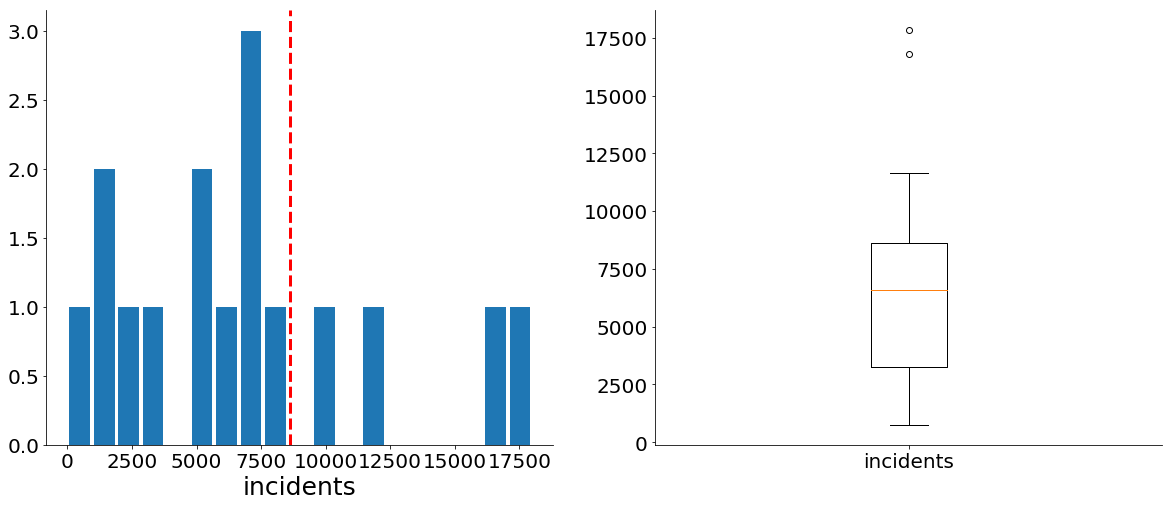

In [26]:
fig = plt.figure(figsize=(20,8))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

bins=np.linspace(0, 18000, num=20)
#bins=list(df_detroit_crime_by_neigh['crime_num_adj'].quantile([0.0, 0.25, 0.5, 0.75,0.95, 1]))

# add histogram to figure
hist = ax0.hist(df_mexico_city_crime_by_district['incidents'], bins=bins , rwidth=0.85)
vertline = ax0.axvline(x=df_mexico_city_crime_by_district['incidents'].quantile(0.75), linestyle='--', linewidth=3, color='red') # create vertical line indicating quantile
hist_xlabel = ax0.set_xlabel('incidents', fontsize=25)
ticks = ax0.tick_params(labelsize=20)

# add boxplot to figure
box = ax1.boxplot(df_mexico_city_crime_by_district['incidents'])
box_label = ax1.set_xticklabels(['incidents'], fontsize=25)

ticks = ax1.tick_params(labelsize=20)
fig.savefig('sample.jpg', bbox_inches='tight')

In the case of Mexico City it seems reasonable to take the 75% quantile as a threshold.

In [27]:
df_mexico_city_crime_by_district[df_mexico_city_crime_by_district['incidents']>df_mexico_city_crime_by_district['incidents'].quantile(0.75)]

district  incidents
19      Benito Juárez       9478
41         Cuauhtémoc      16806
53  Gustavo A. Madero      11644
67         Iztapalapa      17848

Looking at the districts that exceed the 75% quantile we end up with Benito Juárez, Cuathémoc, Gustavo A. Madero and Iztapalapa. As the number of crime incidents in these districts is significantly higher compared to the other districts we would like to exclude all respective neighborhoods from our neighborhood dataset.

One can perfectly see the four districts reflected by the dark red color in the choropleth map above.

In [28]:
df_mexico_city = df_mexico_city.loc[~df_mexico_city['district'].isin(['BENITO JUAREZ', 'CUAUHTEMOC', 'GUSTAVO A. MADERO', 'IZTAPALAPA'])]

<a id='item5'></a>

<a id='item4'></a>

## 5. Clustering Neighborhoods

Now that we have removed the neighborhoods with significant high crime (rates) from the dataframes, we are ready to start with the preparation for the clustering of neighborhoods in Munich, Detroit and Mexico City. Essentially, venue data will be retrieved via the Foursquare API based on the geographic coordinates of the neighborhoods.

#### Set up Foursquare Credentials and Version

Before we can start using the Foursquare API, we need to define the Foursquare credentials and version.

In [29]:
CLIENT_ID = 'LF5N0E54QBB24DDPLUP30HUAJBHPEVVHETZU2DQFVMQKRRFD' # your Foursquare ID
CLIENT_SECRET = 'M5ZQBOKRWQFDT0W4GKVR1YTKG0IWUSNH2AW4UFIMU5S3XR1A' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: LF5N0E54QBB24DDPLUP30HUAJBHPEVVHETZU2DQFVMQKRRFD
CLIENT_SECRET:M5ZQBOKRWQFDT0W4GKVR1YTKG0IWUSNH2AW4UFIMU5S3XR1A


### Extract Venue Data via Foursquare API

We will retrieve venue information in an area specified by the neighborhood coordinates and a radius. This is accomplished by using the explore venue endpoint of the Foursquare API.

We can define a function that makes an API call for all the neighborhoods in a dataframe.

In [30]:
def getNearbyVenues(district, neigh, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for district, neigh, lat, lng in zip(district, neigh, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                district,
                neigh,
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['district', 'neighborhood', 
                      'neighborhood latitude', 
                      'neighborhood longitude', 
                      'venue', 
                      'venue latitude', 
                      'venue longitude', 
                      'venue category']

        except:
            print('No data available for', neigh, ',', district)
            nearby_venues = None
    
    return(nearby_venues)

We can now use this function to retrieve venue information for each city and save the relevant information into a pandas dataframe.

#### Extract Venues for Munich Neighborhoods

Let's start with Munich. Considering the neighborhood map of Munich it appears to be reasonable to stick to the default radius of 500 meters.

In [31]:
munich_venues = getNearbyVenues(district=df_munich['district'],
                                   neigh = df_munich['neighborhood'], 
                                   latitudes=df_munich['latitude'],
                                   longitudes=df_munich['longitude'])

How many venues per neighborhood could be retrieved?

In [32]:
munich_venues.groupby(['district', 'neighborhood']).count()

neighborhood latitude  \
district                                                           neighborhood                                          
Allach - Untermenzing                                              Industriebezirk                                   2   
                                                                   Untermenzing-Allach                               4   
Altstadt - Lehel                                                   Angerviertel                                    100   
                                                                   Englischer Garten Süd                            10   
                                                                   Graggenau                                        88   
                                                                   Hackenviertel                                   100   
                                                                   Kreuzviertel                                     85   
                                                                   Lehel                                            28   
Au - Haidhausen                                                    Haidhausen - Nord                                70   
                                                                   Haidhausen - Süd                                 76   
                                                                   Maximilianeum                                    33   
                                                                   Obere Au                                         27   
                                                                   Steinhausen                                      35   
                                                                   Untere Au                                        37   
Aubing - Lochhausen - Langwied                                     Aubing-Süd                                        8   
                                                                   Freiham                                           3   
                                                                   Lochhausen                                        5   
Berg am Laim                                                       Echarding                                        21   
                                                                   Josephsburg                                      16   
Bogenhausen                                                        Altbogenhausen                                   12   
                                                                   Daglfing                                          5   
                                                                   Englschalking                                    13   
                                                                   Herzogpark                                        3   
                                                                   Johanneskirchen                                   7   
                                                                   Oberföhring                                       4   
                                                                   Parkstadt                                        13   
Feldmoching - Hasenbergl                                           Feldmoching                                      14   
                                                                   Hasenbergl-Lerchenau Ost                          6   
                                                                   Lerchenau West                                    9   
                                                                   Ludwigsfeld                                       4   
Hadern                                                             Blumenau                                         11   
                                                                   Groß

There are quite a few neighborhoods with a very small number of venues. As the clustering algorithm will be based on the venue data that has been retrieved for a specific neighborhood, all neighborhoods with less than 10 venues will be ignored.

In [33]:
# count number of venues per district, neighborhood
munich_venues_count = munich_venues.groupby(['district', 'neighborhood']).count()

# only keep neighborhoods with at least 10 venues 
munich_venues_adj = munich_venues_count[munich_venues_count['venue category']>10]

# create new dataframe that only has neighborhoods with at least 10 venues
df_munich_venues = munich_venues[munich_venues.set_index(['district', 'neighborhood']).index.isin(munich_venues_adj.index)]

print('Shape:', df_munich_venues.shape)
print('Number of unique Neighborhoods:', df_munich_venues['neighborhood'].drop_duplicates().count())
df_munich_venues.reset_index(drop=True, inplace=True)
df_munich_venues.head()

Shape: (2753, 8)
Number of unique Neighborhoods: 74


district neighborhood  neighborhood latitude  \
0  Altstadt - Lehel    Graggenau              48.139616   
1  Altstadt - Lehel    Graggenau              48.139616   
2  Altstadt - Lehel    Graggenau              48.139616   
3  Altstadt - Lehel    Graggenau              48.139616   
4  Altstadt - Lehel    Graggenau              48.139616   

   neighborhood longitude                              venue  venue latitude  \
0               11.579513              Bayerische Staatsoper       48.139639   
1               11.579513            Nationaltheater München       48.139599   
2               11.579513  Hotel Vier Jahreszeiten Kempinski       48.138918   
3               11.579513                           Pusser's       48.138500   
4               11.579513                   Max-Joseph-Platz       48.139817   

   venue longitude venue category  
0        11.578933    Opera House  
1        11.579207    Opera House  
2        11.581775          Hotel  
3        11.580426   Cocktail Bar  
4        11.577886          Plaza

#### Extract Venues for Detroit Neighborhoods

We will use a radius of 700 meters around the center of Detroit neighborhoods to retrieve venue data.

In [34]:
detroit_venues = getNearbyVenues(district=df_detroit['district'],
                                   neigh=df_detroit['neighborhood'], 
                                   latitudes=df_detroit['latitude'],
                                   longitudes=df_detroit['longitude'],
                                 radius=700
                                  )

In [35]:
# count number of venues per district, neighborhood
detroit_venues_count = detroit_venues.groupby(['district', 'neighborhood']).count()

# only keep neighborhoods with at least 10 venues 
detroit_venues_adj = detroit_venues_count[detroit_venues_count['venue category']>10]

# create new dataframe that only has neighborhoods with at least 10 venues
df_detroit_venues = detroit_venues[detroit_venues.set_index(['district', 'neighborhood']).index.isin(detroit_venues_adj.index)]

print('Shape:', df_detroit_venues.shape)
print('Number of unique Neighborhoods:', df_detroit_venues['neighborhood'].drop_duplicates().count())
df_detroit_venues.reset_index(drop=True, inplace=True)
df_detroit_venues.head()

Shape: (1135, 8)
Number of unique Neighborhoods: 55


district          neighborhood  neighborhood latitude  \
0        1  Grand River-St Marys               42.39707   
1        1  Grand River-St Marys               42.39707   
2        1  Grand River-St Marys               42.39707   
3        1  Grand River-St Marys               42.39707   
4        1  Grand River-St Marys               42.39707   

   neighborhood longitude                            venue  venue latitude  \
0              -83.203921                    Family Dollar       42.395321   
1              -83.203921           Universal coney island       42.395325   
2              -83.203921             Little Caesars Pizza       42.392403   
3              -83.203921                Tower Center Mall       42.395337   
4              -83.203921  Captain Jay's Seafood & Chicken       42.402027   

   venue longitude       venue category  
0       -83.202382       Discount Store  
1       -83.202372                Diner  
2       -83.199267          Pizza Place  
3       -83.202364        Shopping Mall  
4       -83.199023  Fried Chicken Joint

#### Extract Venues for Mexico City Neighborhoods

In [36]:
mexico_city_venues = getNearbyVenues(district=df_mexico_city['district'],
                                   neigh = df_mexico_city['neighborhood'], 
                                   latitudes=df_mexico_city['latitude'],
                                   longitudes=df_mexico_city['longitude'],
                                     radius=400)

In [37]:
# count number of venues per district, neighborhood
mexico_city_venues_count = mexico_city_venues.groupby(['district', 'neighborhood']).count()

# only keep neighborhoods with at least 10 venues 
mexico_city_venues_adj = mexico_city_venues_count[mexico_city_venues_count['venue category']>10]

# create new dataframe that only has neighborhoods with at least 10 venues
df_mexico_city_venues = mexico_city_venues[mexico_city_venues.set_index(['district', 'neighborhood']).index.isin(mexico_city_venues_adj.index)]

print('Shape:', df_mexico_city_venues.shape)
print('Number of unique Neighborhoods:', df_mexico_city_venues['neighborhood'].drop_duplicates().count())
df_mexico_city_venues.reset_index(drop=True, inplace=True)
df_mexico_city_venues.head()

Shape: (14555, 8)
Number of unique Neighborhoods: 596


district neighborhood  neighborhood latitude  neighborhood longitude  \
0  AZCAPOTZALCO    PETROLERA              19.485156              -99.199994   
1  AZCAPOTZALCO    PETROLERA              19.485156              -99.199994   
2  AZCAPOTZALCO    PETROLERA              19.485156              -99.199994   
3  AZCAPOTZALCO    PETROLERA              19.485156              -99.199994   
4  AZCAPOTZALCO    PETROLERA              19.485156              -99.199994   

                        venue  venue latitude  venue longitude  \
0            Los Pit's México       19.484625       -99.198399   
1               la michoacana       19.485082       -99.200502   
2         Deportivo Benavides       19.484359       -99.201828   
3  La Cochinita de la Abuela.       19.484757       -99.198923   
4              Poderoso's GYM       19.484036       -99.198126   

         venue category  
0            Food Truck  
1        Ice Cream Shop  
2                  Pool  
3                 Diner  
4  Gym / Fitness Center

### Prepare Data Frame for k-means Clustering

In order to apply the k-means clustering algorithm to the neighborhoods of Munich, Detroit and Mexico City, we have to put all the data into a single dataframe. Before, let's assign the city names accordingly.

In [38]:
df_munich_venues.insert(0, 'city', 'Munich')
df_detroit_venues.insert(0, 'city', 'Detroit')
df_mexico_city_venues.insert(0, 'city', 'Mexico City')

df_munich_venues.head()


city          district neighborhood  neighborhood latitude  \
0  Munich  Altstadt - Lehel    Graggenau              48.139616   
1  Munich  Altstadt - Lehel    Graggenau              48.139616   
2  Munich  Altstadt - Lehel    Graggenau              48.139616   
3  Munich  Altstadt - Lehel    Graggenau              48.139616   
4  Munich  Altstadt - Lehel    Graggenau              48.139616   

   neighborhood longitude                              venue  venue latitude  \
0               11.579513              Bayerische Staatsoper       48.139639   
1               11.579513            Nationaltheater München       48.139599   
2               11.579513  Hotel Vier Jahreszeiten Kempinski       48.138918   
3               11.579513                           Pusser's       48.138500   
4               11.579513                   Max-Joseph-Platz       48.139817   

   venue longitude venue category  
0        11.578933    Opera House  
1        11.579207    Opera House  
2        11.581775          Hotel  
3        11.580426   Cocktail Bar  
4        11.577886          Plaza

Now we are ready to merge the three dataframes into a single one.

In [39]:
df_neighborhoods = pd.concat([df_munich_venues, df_detroit_venues, df_mexico_city_venues])

print(df_neighborhoods.shape)
df_neighborhoods.head()

(18443, 9)


city          district neighborhood  neighborhood latitude  \
0  Munich  Altstadt - Lehel    Graggenau              48.139616   
1  Munich  Altstadt - Lehel    Graggenau              48.139616   
2  Munich  Altstadt - Lehel    Graggenau              48.139616   
3  Munich  Altstadt - Lehel    Graggenau              48.139616   
4  Munich  Altstadt - Lehel    Graggenau              48.139616   

   neighborhood longitude                              venue  venue latitude  \
0               11.579513              Bayerische Staatsoper       48.139639   
1               11.579513            Nationaltheater München       48.139599   
2               11.579513  Hotel Vier Jahreszeiten Kempinski       48.138918   
3               11.579513                           Pusser's       48.138500   
4               11.579513                   Max-Joseph-Platz       48.139817   

   venue longitude venue category  
0        11.578933    Opera House  
1        11.579207    Opera House  
2        11.581775          Hotel  
3        11.580426   Cocktail Bar  
4        11.577886          Plaza

Let's see how many unique categories can be curated from all the returned venues

In [40]:
print('There are {} unique categories.'.format(len(df_neighborhoods['venue category'].unique())))

There are 467 unique categories.


The next step is to apply one hot encoding in order to finally obtain a data frame that can be used as input for the k-means clustering algorithm.

In [41]:
df_neighborhoods_onehot = pd.get_dummies(df_neighborhoods[['venue category']], prefix="", prefix_sep="")

# add City, District and Neighborhood columns back to the dataframe
df_neighborhoods_onehot['city'] = df_neighborhoods['city']
df_neighborhoods_onehot['district'] = df_neighborhoods['district']
df_neighborhoods_onehot['neighborhood'] = df_neighborhoods['neighborhood']

# move city, district and neighborhood columns to the front
fixed_columns = list(df_neighborhoods_onehot.columns[-3:]) + list(df_neighborhoods_onehot.columns[:-3])
df_neighborhoods_onehot = df_neighborhoods_onehot[fixed_columns]

print(df_neighborhoods_onehot.shape)
df_neighborhoods_onehot.head()


(18443, 470)


city          district neighborhood  ATM  Accessories Store  \
0  Munich  Altstadt - Lehel    Graggenau    0                  0   
1  Munich  Altstadt - Lehel    Graggenau    0                  0   
2  Munich  Altstadt - Lehel    Graggenau    0                  0   
3  Munich  Altstadt - Lehel    Graggenau    0                  0   
4  Munich  Altstadt - Lehel    Graggenau    0                  0   

   Adult Boutique  Afghan Restaurant  African Restaurant  Alternative Healer  \
0               0                  0                   0                   0   
1               0                  0                   0                   0   
2               0                  0                   0                   0   
3               0                  0                   0                   0   
4               0                  0                   0                   0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                    0             0       0                 0   
1                    0             0       0                 0   
2                    0             0       0                 0   
3                    0             0       0                 0   
4                    0             0       0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Astrologer  Athletics & Sports  \
0                     0                 0           0                   0   
1                     0                 0           0                   0   
2                     0                 0           0                   0   
3                     0                 0           0                   0   
4                     0                 0           0                   0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                      0                    0            0              0   
1                      0                    0            0              0   
2                      0                    0            0              0   
3                      0                    0            0              0   
4                      0                    0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0                0          0           0           0       0     0    0   
1                0          0           0           0       0     0    0   
2                0          0           0           0       0     0    0   
3                0          0           0           0       0     0    0   
4                0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Bavarian Restaurant  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0                    0      0                0         0            0   
1                    0      0                0         0            0   
2                    0      0                0         0            0   
3                    0      0                0         0            0   
4                    0      0                0         0

Calculate the mean in order to obtain a single row reflecting a specific neighborhood.

In [42]:
df_neighborhoods_grouped = df_neighborhoods_onehot.groupby(['city', 'district', 'neighborhood']).mean().reset_index()
df_neighborhoods_grouped.head()

city district          neighborhood  ATM  Accessories Store  \
0  Detroit        1    Cadillac Community  0.0                0.0   
1  Detroit        1           Five Points  0.0                0.0   
2  Detroit        1  Grand River-St Marys  0.0                0.0   
3  Detroit        1   McNichols Evergreen  0.0                0.0   
4  Detroit        1          Miller Grove  0.0                0.0   

   Adult Boutique  Afghan Restaurant  African Restaurant  Alternative Healer  \
0             0.0                0.0                 0.0            0.000000   
1             0.0                0.0                 0.0            0.000000   
2             0.0                0.0                 0.0            0.000000   
3             0.0                0.0                 0.0            0.071429   
4             0.0                0.0                 0.0            0.000000   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0             0.058824           0.0     0.0               0.0   
1             0.000000           0.0     0.0               0.0   
2             0.000000           0.0     0.0               0.0   
3             0.000000           0.0     0.0               0.0   
4             0.000000           0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0          0.0         0.0                  0.0   
1                     0.0          0.0         0.0                  0.0   
2                     0.0          0.0         0.0                  0.0   
3                     0.0          0.0         0.0                  0.0   
4                     0.0          0.0         0.0                  0.0   

   Arts & Entertainment  Asian Restaurant  Astrologer  Athletics & Sports  \
0                   0.0               0.0         0.0                 0.0   
1                   0.0               0.0         0.0                 0.0   
2                   0.0               0.0         0.0                 0.0   
3                   0.0               0.0         0.0                 0.0   
4                   0.0               0.0         0.0                 0.0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                    0.0                  0.0          0.0       0.000000   
1                    0.0                  0.0          0.0       0.000000   
2                    0.0                  0.0          0.0       0.000000   
3                    0.0                  0.0          0.0       0.071429   
4                    0.0                  0.0          0.0       0.000000   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop    Bakery      Bank  \
0              0.0        0.0         0.0         0.0  0.000000  0.000000   
1              0.0        0.0         0.0         0.0  0.000000  0.076923   
2              0.0        0.0         0.0         0.0  0.076923  0.000000   
3              0.0        0.0         0.0         0.0  0.000000  0.000000   
4              0.0        0.0         0.0         0.0  0.000000  0.000000   

        Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0  0.000000             0.0               0.0               0.0   
1  0.000000             0.0               0.0               0.0   
2  0.000000             0.0               0.0               0.0   
3  0.071429             0.0               0.0               0.0   
4  0.090909             0.0               0.0               0.0   

   Basketball Stadium  Bavarian Restaurant  Beach  Bed & Breakfast  Beer Bar  \
0                 0.0                  0.0    0.0              0.0       0.0   
1                 0.0                  0.0    0.0              0.0       0.0   
2                 0.0                  0.0    0.0              0.0       0.0   
3                 0.0                  0.0    0.0              0.0       0.0   
4                 0.0                  0.0    0.0              0.0    

Finally, we would like to reduce the feature size, i.e. the number of venue categories. Thus, let's drop some less important columns. 

In [43]:
# drop columns other than venue categories
df_neighborhoods_grouped_clustering = df_neighborhoods_grouped.drop(['city', 'district', 'neighborhood'], 1)

# calculate the sum of the columns
df_neighborhoods_grouped_clustering.loc['Total'] = df_neighborhoods_grouped_clustering.sum()

print("Before removing features:", df_neighborhoods_grouped_clustering.shape)

# #only keep features where sum > specified value
# df_neighborhoods_grouped_clustering = df_neighborhoods_grouped_clustering.loc[:, (df_neighborhoods_grouped_clustering.loc['Total'] > 0.5)] 

print("After removing features:", df_neighborhoods_grouped_clustering.shape)

# remove the total column again
df_neighborhoods_grouped_clustering.drop(index=['Total'], inplace=True)


Before removing features: (734, 467)
After removing features: (734, 467)


This data frame can now be used to train the k-means clustering model.

### Get Top 10 Venues per Neighborhood

But before we start to derive cluster labels for the specific neighborhoods, we would like to give the top 10 venues per neighborhood. In order to do so, we will use a function provided by one of the labs of the Applied Data Science Capstone course. This function returns the most common venues for a specific neighborhood.

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city', 'district', 'neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['city'] = df_neighborhoods_grouped['city']
neighborhoods_venues_sorted['district'] = df_neighborhoods_grouped['district']
neighborhoods_venues_sorted['neighborhood'] = df_neighborhoods_grouped['neighborhood']

for ind in np.arange(df_neighborhoods_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 3:] = return_most_common_venues(df_neighborhoods_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)    
neighborhoods_venues_sorted.head()

(733, 13)


city district          neighborhood 1st Most Common Venue  \
0  Detroit        1    Cadillac Community        Cosmetics Shop   
1  Detroit        1           Five Points          Intersection   
2  Detroit        1  Grand River-St Marys           Pizza Place   
3  Detroit        1   McNichols Evergreen                  Café   
4  Detroit        1          Miller Grove  Gym / Fitness Center   

  2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
0     Convenience Store    Chinese Restaurant               Shoe Store   
1         Grocery Store     Fish & Chips Shop              Gas Station   
2          Liquor Store   Fried Chicken Joint           Discount Store   
3     Convenience Store                   Bar           Discount Store   
4    Chinese Restaurant          Intersection  New American Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0        Clothing Store           Pizza Place         Deli / Bodega   
1     Mobile Phone Shop                  Bank          Liquor Store   
2         Deli / Bodega  Fast Food Restaurant                Bakery   
3          Home Service  Fast Food Restaurant         Hot Dog Joint   
4           Supermarket                   Bar                  Café   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0          Optical Shop    Seafood Restaurant    American Restaurant  
1        Sandwich Place            Restaurant             Donut Shop  
2          Intersection         Women's Store          Shopping Mall  
3   Fried Chicken Joint         Auto Workshop     Seafood Restaurant  
4        Sandwich Place        Discount Store          Deli / Bodega

### Apply k-means Algorithm

In [46]:
df_neighborhoods_grouped_clustering.head()

ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0  0.0                0.0             0.0                0.0   
1  0.0                0.0             0.0                0.0   
2  0.0                0.0             0.0                0.0   
3  0.0                0.0             0.0                0.0   
4  0.0                0.0             0.0                0.0   

   African Restaurant  Alternative Healer  American Restaurant  Antique Shop  \
0                 0.0            0.000000             0.058824           0.0   
1                 0.0            0.000000             0.000000           0.0   
2                 0.0            0.000000             0.000000           0.0   
3                 0.0            0.071429             0.000000           0.0   
4                 0.0            0.000000             0.000000           0.0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0     0.0               0.0                     0.0          0.0         0.0   
1     0.0               0.0                     0.0          0.0         0.0   
2     0.0               0.0                     0.0          0.0         0.0   
3     0.0               0.0                     0.0          0.0         0.0   
4     0.0               0.0                     0.0          0.0         0.0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  Astrologer  \
0                  0.0                   0.0               0.0         0.0   
1                  0.0                   0.0               0.0         0.0   
2                  0.0                   0.0               0.0         0.0   
3                  0.0                   0.0               0.0         0.0   
4                  0.0                   0.0               0.0         0.0   

   Athletics & Sports  Australian Restaurant  Austrian Restaurant  \
0                 0.0                    0.0                  0.0   
1                 0.0                    0.0                  0.0   
2                 0.0                    0.0                  0.0   
3                 0.0                    0.0                  0.0   
4                 0.0                    0.0                  0.0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0          0.0       0.000000              0.0        0.0         0.0   
1          0.0       0.000000              0.0        0.0         0.0   
2          0.0       0.000000              0.0        0.0         0.0   
3          0.0       0.071429              0.0        0.0         0.0   
4          0.0       0.000000              0.0        0.0         0.0   

   Bagel Shop    Bakery      Bank       Bar  Baseball Field  Baseball Stadium  \
0         0.0  0.000000  0.000000  0.000000             0.0               0.0   
1         0.0  0.000000  0.076923  0.000000             0.0               0.0   
2         0.0  0.076923  0.000000  0.000000             0.0               0.0   
3         0.0  0.000000  0.000000  0.071429             0.0               0.0   
4         0.0  0.000000  0.000000  0.090909             0.0               0.0   

   Basketball Court  Basketball Stadium  Bavarian Restaurant  Beach  \
0               0.0                 0.0                  0.0    0.0   
1               0.0                 0.0                  0.0    0.0   
2               0.0                 0.0                  0.0    0.0   
3               0.0                 0.0                  0.0    0.0   
4               0.0                 0.0                  0.0    0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  \
0              0.0       0.0          0.0         0.0                 0.0   
1              0.0       0.0          0.0         0.0                 0.0   
2              0.0       0.0          0.0         0.0                 0.0   
3              0.0       0.0          0.0         0.0                 0.0   
4              0.0       0.0      

Let's run k-means algorithm for a range of k values and calculate the sum of squared distances. This is known as elbow function and it can be used to identify the optimal k value.

In [48]:
sum_of_squared_distances = []

K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(df_neighborhoods_grouped_clustering)
    sum_of_squared_distances.append(km.inertia_)

Let's plot the elbow function.

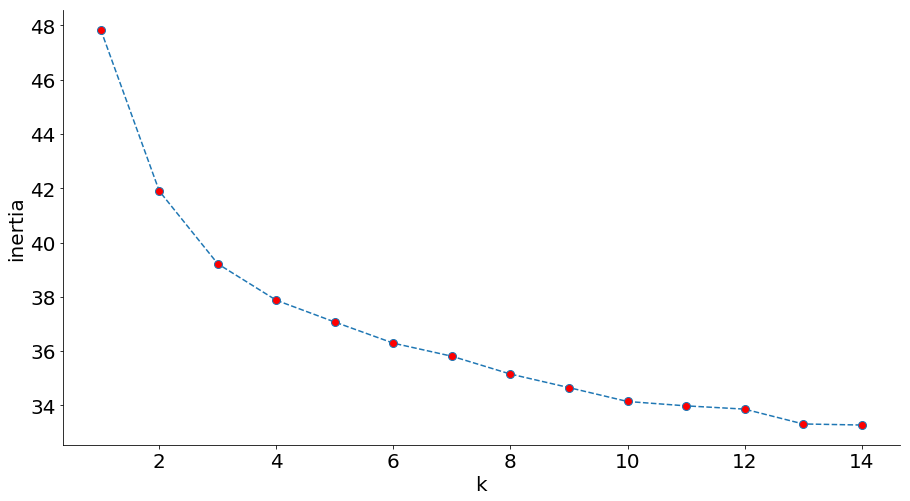

In [49]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(K, sum_of_squared_distances, linestyle='--', marker = 'o', markersize = 8, markerfacecolor = 'red')
ax.set_xlabel('k', fontsize = 20)
ax.set_ylabel('inertia', fontsize = 20)
ax.tick_params(labelsize=20)

fig.savefig('elbow.jpg', bbox_inches='tight')

As can be seen from the figure above, the elbow point is k = 4. We will use this value to run the k-means algorithm again.

In [50]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_neighborhoods_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Let's bring up the labels and venue information in the original datasets now...

In [51]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster', kmeans.labels_)

# split venue dataframe into one for each city
neighborhoods_venues_sorted_munich = neighborhoods_venues_sorted[neighborhoods_venues_sorted['city']=='Munich']
neighborhoods_venues_sorted_detroit = neighborhoods_venues_sorted[neighborhoods_venues_sorted['city']=='Detroit']
neighborhoods_venues_sorted_mexico_city = neighborhoods_venues_sorted[neighborhoods_venues_sorted['city']=='Mexico City']

# add venue ranking per neighborhood to the original dataframes
munich_merged = df_munich.set_index(['district', 'neighborhood']).join(neighborhoods_venues_sorted_munich.set_index(['district', 'neighborhood']))
detroit_merged = df_detroit.set_index(['district', 'neighborhood']).join(neighborhoods_venues_sorted_detroit.set_index(['district', 'neighborhood']))
mexico_city_merged = df_mexico_city.set_index(['district', 'neighborhood']).join(neighborhoods_venues_sorted_mexico_city.set_index(['district', 'neighborhood']))

# remove neighborhoods without venue information
munich_merged = munich_merged[munich_merged['cluster'].notnull()].reset_index()
detroit_merged = detroit_merged[detroit_merged['cluster'].notnull()].reset_index()
mexico_city_merged = mexico_city_merged[mexico_city_merged['cluster'].notnull()].reset_index()

# convert cluster labels column 
munich_merged['cluster'] = munich_merged['cluster'].astype('int64')
detroit_merged['cluster'] = detroit_merged['cluster'].astype('int64')
mexico_city_merged['cluster'] = mexico_city_merged['cluster'].astype('int64')

# drop non-relevant columns
munich_merged.drop(columns=['city'], inplace=True)
detroit_merged.drop(columns=['city', 'acres', 'incidents', 'crime rate'], inplace=True)
mexico_city_merged.drop(columns=['city'], inplace=True)

Let's have a look at the final dataframes ...

In [52]:
print(munich_merged.shape)
munich_merged.head()

(74, 15)


district   neighborhood   latitude  longitude  cluster  \
0  Altstadt - Lehel      Graggenau  48.139616  11.579513        2   
1  Altstadt - Lehel   Angerviertel  48.133670  11.571569        2   
2  Altstadt - Lehel  Hackenviertel  48.135731  11.569955        2   
3  Altstadt - Lehel   Kreuzviertel  48.139698  11.573209        2   
4  Altstadt - Lehel          Lehel  48.139656  11.587921        2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Café                 Hotel                 Plaza   
1                  Café                 Plaza        Clothing Store   
2                  Café     German Restaurant   Bavarian Restaurant   
3                 Plaza                  Café        Clothing Store   
4     German Restaurant    Italian Restaurant                 Plaza   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0   Bavarian Restaurant          Cocktail Bar              Boutique   
1                 Hotel          Cocktail Bar           Coffee Shop   
2        Clothing Store                 Plaza              Boutique   
3   Bavarian Restaurant     German Restaurant              Boutique   
4                   Bar      Insurance Office            Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Restaurant        Clothing Store     German Restaurant   
1     German Restaurant   Bavarian Restaurant              Tea Room   
2           Coffee Shop          Cocktail Bar                Church   
3           Coffee Shop      Department Store     French Restaurant   
4             Surf Spot      Sushi Restaurant           Snack Place   

  10th Most Common Venue  
0            Opera House  
1                 Church  
2                 Museum  
3             Restaurant  
4      Outdoor Sculpture

In [53]:
detroit_merged.head()

district          neighborhood   latitude  longitude  cluster  \
0        1  Grand River-St Marys  42.397070 -83.203921        2   
1        1      Seven Mile-Rouge  42.431515 -83.273021        2   
2        1    Cadillac Community  42.389906 -83.194906        2   
3        1   McNichols Evergreen  42.411816 -83.241963        2   
4        1          South of Six  42.410997 -83.281921        2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Pizza Place          Liquor Store   Fried Chicken Joint   
1    Chinese Restaurant            Restaurant            Donut Shop   
2        Cosmetics Shop     Convenience Store    Chinese Restaurant   
3                  Café     Convenience Store                   Bar   
4           Pizza Place          Liquor Store  Marijuana Dispensary   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        Discount Store         Deli / Bodega  Fast Food Restaurant   
1           Golf Course                  Bank    Seafood Restaurant   
2            Shoe Store        Clothing Store           Pizza Place   
3        Discount Store          Home Service  Fast Food Restaurant   
4    Chinese Restaurant       Automotive Shop              Pharmacy   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Bakery          Intersection         Women's Store   
1        Sandwich Place         Deli / Bodega     Mobile Phone Shop   
2         Deli / Bodega          Optical Shop    Seafood Restaurant   
3         Hot Dog Joint   Fried Chicken Joint         Auto Workshop   
4              Wine Bar                   Bar          Intersection   

  10th Most Common Venue  
0          Shopping Mall  
1         Cosmetics Shop  
2    American Restaurant  
3     Seafood Restaurant  
4   Gym / Fitness Center

In [54]:
mexico_city_merged.head()

district                  neighborhood   latitude  longitude  cluster  \
0  AZCAPOTZALCO                     PETROLERA  19.485156 -99.199994        1   
1  AZCAPOTZALCO          AMPLIACION PETROLERA  19.483038 -99.195313        1   
2  AZCAPOTZALCO  CRUZ ROJA TEPANTONGO (U HAB)  19.500233 -99.184809        1   
3  AZCAPOTZALCO                       LA RAZA  19.465825 -99.146543        3   
4  AZCAPOTZALCO              FERRERIA (U HAB)  19.498699 -99.176806        3   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    Mexican Restaurant     Convenience Store            Food Truck   
1  Gym / Fitness Center     Convenience Store                Bakery   
2                  Pool    Mexican Restaurant     Convenience Store   
3           Coffee Shop  Gym / Fitness Center                  Café   
4          Concert Hall            Taco Place           Beer Garden   

  4th Most Common Venue            5th Most Common Venue  \
0  Gym / Fitness Center                              Gym   
1    Mexican Restaurant                           Lounge   
2         Track Stadium                     Tennis Court   
3    Mexican Restaurant                       Restaurant   
4                  Park  Southern / Soul Food Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                  Café                 Diner             Cafeteria   
1                Market            Food Truck           Flea Market   
2    Athletics & Sports         Memorial Site  Fast Food Restaurant   
3        Breakfast Spot           Salad Place        Ice Cream Shop   
4               Stadium    Mexican Restaurant                  Café   

  9th Most Common Venue 10th Most Common Venue  
0        Baseball Field            Pizza Place  
1           Event Space            Dry Cleaner  
2            Taco Place       Basketball Court  
3           Snack Place                  Hotel  
4             Racetrack      Electronics Store

<a id='item6'></a>

## 6. Examine Clusters

Now that we have all the information we need in our dataframes let us investigate them in more detail.

### Visualize Clusters on Map

First, we can visualize the neighborhoods in our three cities to see the distribution of the clusters.

In [57]:
# create map of Munich using latitude and longitude values
map_munich_clusters = folium.Map(location=[city_locations.iloc[0, 0], city_locations.iloc[0,1]], zoom_start=12, control_scale=True)

# neighborhoods = plugins.MarkerCluster().add_to(map_munich)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, district, neighborhood, cluster in zip(munich_merged['latitude'], munich_merged['longitude'], munich_merged['district'], munich_merged['neighborhood'], munich_merged['cluster']):
    label = folium.Popup(str(neighborhood) + ' , ' + str(district) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_munich_clusters)

map_munich_clusters


In [58]:
# create map of Detroit using latitude and longitude values
# map_detroit_clusters = folium.Map(location=[city_locations.iloc[1, 0], city_locations.iloc[1,1]], zoom_start=12, control_scale=True)
map_detroit_clusters = folium.Map(location=[42.361650, -83.093222], zoom_start = 12, control_scale=True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, district, neighborhood, cluster in zip(detroit_merged['latitude'], detroit_merged['longitude'], detroit_merged['district'], detroit_merged['neighborhood'], detroit_merged['cluster']):
    label = folium.Popup(str(neighborhood) + ' , ' + str(district) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_detroit_clusters)
    
map_detroit_clusters

In [59]:
# create map of Mexico City using latitude and longitude values
# map_mexico_city_clusters = folium.Map(location=[city_locations.iloc[2, 0], city_locations.iloc[2,1]], zoom_start=11, control_scale=True)
map_mexico_city_clusters = folium.Map(location=[19.321834, -99.134788], zoom_start=11, control_scale=True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, district, neighborhood, cluster in zip(mexico_city_merged['latitude'], mexico_city_merged['longitude'], mexico_city_merged['district'], mexico_city_merged['neighborhood'], mexico_city_merged['cluster']):
    label = folium.Popup(str(neighborhood) + ' , ' + str(district) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_mexico_city_clusters)
    
map_mexico_city_clusters


Let's have a look at the neighborhoods that end up in the same clusters. Therefore, filter on the cluster label ...

### Investigate Top 10 Venues in Clusters

#### Cluster 1

In [67]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster']==0, :].head()

cluster         city        district         neighborhood  \
55        0  Mexico City  ALVARO OBREGON         1RA VICTORIA   
57        0  Mexico City  ALVARO OBREGON   AGUILAS 3ER PARQUE   
61        0  Mexico City  ALVARO OBREGON         ALFONSO XIII   
64        0  Mexico City  ALVARO OBREGON   ARBOLEDAS POLITOCO   
68        0  Mexico City  ALVARO OBREGON  BALCONES DE CEHUAYO   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
55            Taco Place    Mexican Restaurant                  Park   
57            Taco Place     Convenience Store            Hobby Shop   
61            Taco Place    Mexican Restaurant    Seafood Restaurant   
64            Taco Place    Mexican Restaurant          Burger Joint   
68            Taco Place    Mexican Restaurant                  Park   

   4th Most Common Venue 5th Most Common Venue  6th Most Common Venue  \
55          Burger Joint    Seafood Restaurant  General Entertainment   
57     Electronics Store                   Gym   Gym / Fitness Center   
61                  Café        Farmers Market           Burger Joint   
64     Convenience Store      Department Store           Neighborhood   
68                Bakery             BBQ Joint            Coffee Shop   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
55                 Track      Basketball Court               Theater   
57                   Bar                Bakery              Pharmacy   
61           Beer Garden                Bakery           Snack Place   
64        Farmers Market                  Café  Gym / Fitness Center   
68      Basketball Court           Flea Market           Fish Market   

   10th Most Common Venue  
55                    Bar  
57            Pizza Place  
61              BBQ Joint  
64           Liquor Store  
68    Dumpling Restaurant

#### Cluster 2

In [68]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster']==1, :].head()

cluster     city district       neighborhood 1st Most Common Venue  \
42        1  Detroit        6  Central Southwest    Mexican Restaurant   
45        1  Detroit        6      Hubbard Farms    Mexican Restaurant   
46        1  Detroit        6    Hubbard Richard    Mexican Restaurant   
47        1  Detroit        6        Mexicantown    Mexican Restaurant   
48        1  Detroit        6    Michigan-Martin    Mexican Restaurant   

        2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
42             Discount Store           Pizza Place  Fast Food Restaurant   
45                Pizza Place              Tiki Bar            Restaurant   
46                Supermarket           Coffee Shop       Border Crossing   
47                 Taco Place           Art Gallery                   Bar   
48  Latin American Restaurant        Ice Cream Shop           Pizza Place   

   5th Most Common Venue      6th Most Common Venue 7th Most Common Venue  \
42                  Bank  Latin American Restaurant                 Diner   
45          Dessert Shop                     Bakery             Gift Shop   
46          Cocktail Bar               Noodle House          Dance Studio   
47           Pizza Place              Movie Theater        Duty-free Shop   
48            Smoke Shop              Grocery Store                   Bar   

   8th Most Common Venue  9th Most Common Venue  10th Most Common Venue  
42    Seafood Restaurant      Mobile Phone Shop     Fried Chicken Joint  
45            Taco Place  Vietnamese Restaurant                     Bar  
46         Big Box Store              Rest Area            Burger Joint  
47               Theater                 Bakery  Transportation Service  
48           Supermarket    American Restaurant         Cultural Center

#### Cluster 3

In [69]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster']==2, :].head()

cluster     city district          neighborhood 1st Most Common Venue  \
0        2  Detroit        1    Cadillac Community        Cosmetics Shop   
1        2  Detroit        1           Five Points          Intersection   
2        2  Detroit        1  Grand River-St Marys           Pizza Place   
3        2  Detroit        1   McNichols Evergreen                  Café   
4        2  Detroit        1          Miller Grove  Gym / Fitness Center   

  2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
0     Convenience Store    Chinese Restaurant               Shoe Store   
1         Grocery Store     Fish & Chips Shop              Gas Station   
2          Liquor Store   Fried Chicken Joint           Discount Store   
3     Convenience Store                   Bar           Discount Store   
4    Chinese Restaurant          Intersection  New American Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0        Clothing Store           Pizza Place         Deli / Bodega   
1     Mobile Phone Shop                  Bank          Liquor Store   
2         Deli / Bodega  Fast Food Restaurant                Bakery   
3          Home Service  Fast Food Restaurant         Hot Dog Joint   
4           Supermarket                   Bar                  Café   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0          Optical Shop    Seafood Restaurant    American Restaurant  
1        Sandwich Place            Restaurant             Donut Shop  
2          Intersection         Women's Store          Shopping Mall  
3   Fried Chicken Joint         Auto Workshop     Seafood Restaurant  
4        Sandwich Place        Discount Store          Deli / Bodega

#### Cluster 4

In [70]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster']==3, :].head()

cluster         city        district         neighborhood  \
43        3      Detroit               6             Claytown   
59        3  Mexico City  ALVARO OBREGON         ALCANTARILLA   
62        3  Mexico City  ALVARO OBREGON                ALPES   
63        3  Mexico City  ALVARO OBREGON         ALPES (AMPL)   
65        3  Mexico City  ALVARO OBREGON  ARCOS DE CENTENARIO   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
43    Mexican Restaurant        Cosmetics Shop         Grocery Store   
59        Ice Cream Shop    Italian Restaurant         Shopping Mall   
62           Coffee Shop   Sporting Goods Shop            Taco Place   
63                  Food            Taco Place              Pharmacy   
65          Burger Joint           Pizza Place     Convenience Store   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
43                Bakery        Sandwich Place        Discount Store   
59            Restaurant      Tapas Restaurant                Bakery   
62         Movie Theater    Mexican Restaurant         Shopping Mall   
63           Flea Market                  Park    Mexican Restaurant   
65      Stationery Store    Seafood Restaurant              Pharmacy   

     7th Most Common Venue  8th Most Common Venue      9th Most Common Venue  \
43               Pet Store                   Food  Latin American Restaurant   
59              Taco Place          Garden Center           Sushi Restaurant   
62  Argentinian Restaurant             Food Court                 Boxing Gym   
63      Athletics & Sports  Performing Arts Venue                  Pet Store   
65      Mexican Restaurant            Fabric Shop                 Taco Place   

   10th Most Common Venue  
43            Pizza Place  
59             Food Stand  
62       Sushi Restaurant  
63                    Spa  
65            Film Studio

### Build Wordcloud for Clusters

Let's build a word cloud for each cluster to get an impression of the characteristics and infrastructure. There is some data manipulation required in order to generate the data input for building the word clouds.

In [64]:
# add cluster labels 
df_neighborhoods_wc = df_neighborhoods.set_index(['city', 'district', 'neighborhood']).join(neighborhoods_venues_sorted.set_index(['city', 'district', 'neighborhood']))

# only keep relevant data
df_neighborhoods_wc = df_neighborhoods_wc[['venue category', 'cluster']].reset_index()

print(df_neighborhoods_wc.shape)
df_neighborhoods_wc.head()

(18443, 5)


city district        neighborhood      venue category  cluster
0  Detroit        1  Cadillac Community         Pizza Place        2
1  Detroit        1  Cadillac Community          Shoe Store        2
2  Detroit        1  Cadillac Community       Grocery Store        2
3  Detroit        1  Cadillac Community        Optical Shop        2
4  Detroit        1  Cadillac Community  Chinese Restaurant        2

In [65]:
# remove any redundant stopwords
stopwords = list(STOPWORDS)

We will now loop through all the clusters and create a dictionary containing the venues along with the frequency in each cluster in a first step. Then a word cloud object is created and visualized accordingly.

Cluster 1


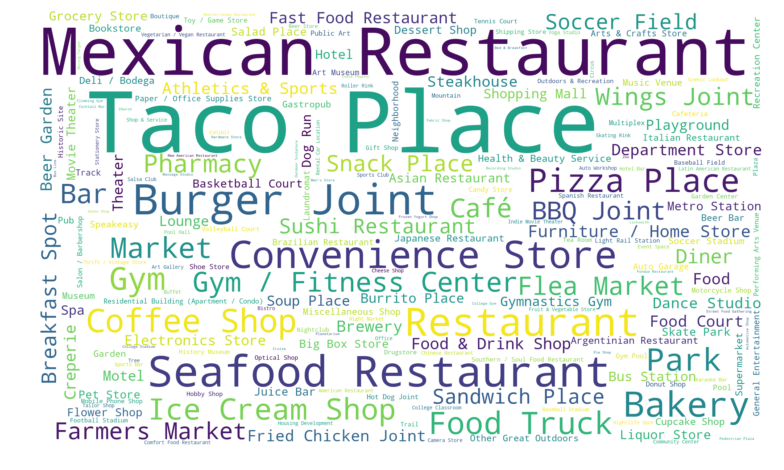

Cluster 2


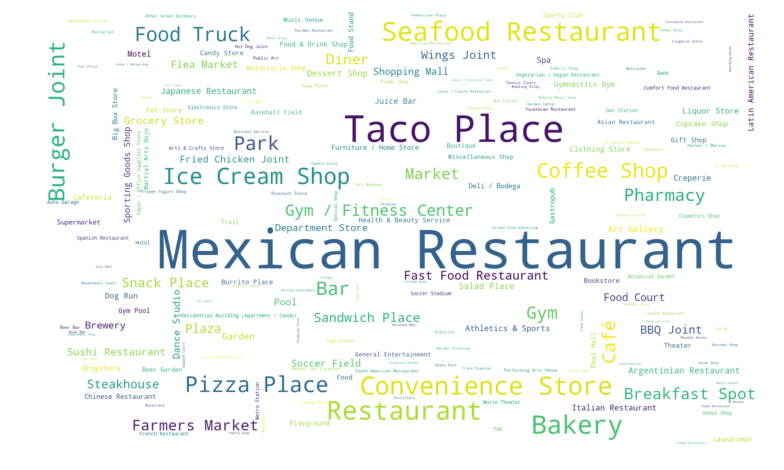

Cluster 3


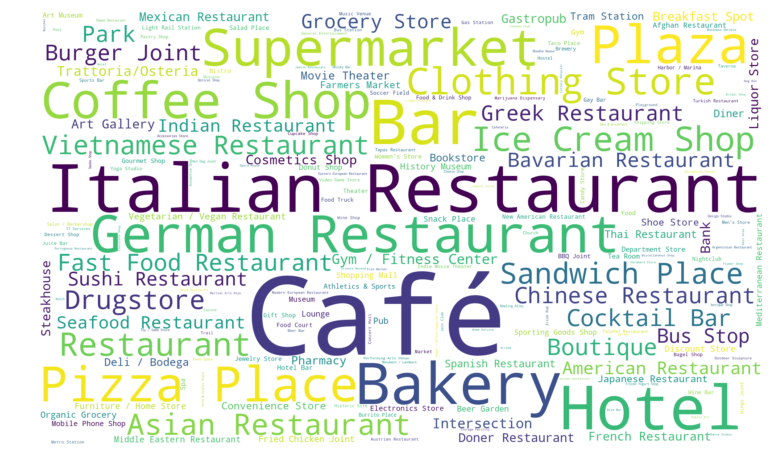

Cluster 4


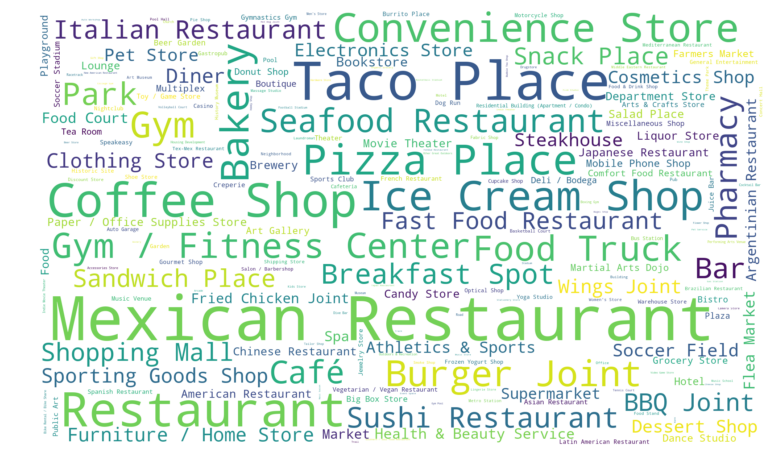

In [66]:
# create and visualize a wordcloud for each cluster in the dataframe

for i in range(0, df_neighborhoods_wc['cluster'].max() + 1):
        
    # build dictionary with venues and frequencies
    temp = df_neighborhoods_wc[df_neighborhoods_wc['cluster'] == i]['venue category'].value_counts().to_frame().rename(columns = {'venue category': 'frequency'})
    temp['frequency'] = temp['frequency'] / temp['frequency'].sum()
    temp.reset_index(inplace=True)
    temp.rename(columns = {'index': 'venue'}, inplace=True)
      
    dict = {}
    for index, row in temp.iterrows():
        dict[row['venue']] = row['frequency'] 
       
    # instantiate a word cloud object
    cluster_wc = WordCloud(
    stopwords=stopwords,
    background_color='white',
    width=2000,
    height=1200
    )
    
    # generate the word cloud
    cluster_wc.generate_from_frequencies(dict)
    
    print('Cluster', i + 1)
    
    # display the word cloud
    fig = plt.figure()
    fig.set_figwidth(20) # set width
    fig.set_figheight(8) # set height

    plt.imshow(cluster_wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    